# Introduction

This notebook is focused on getting a feel for the Perceptron.  This is similar information to the very nice [webpage](http://sebastianraschka.com/Articles/2015_singlelayer_neurons.html) by Sebastian Raschka, which has very good graphics. He covers all this material much better there, although his code is Python instead of Julia.  As with the other notebooks in this series, I hope it helps people get a better feel for using the [Julia](http://julialang.org/) programming language.

This notebook was originally designed as an adjunct to a [talk I gave](https://www.meetup.com/Monterey-Bay-Data-Science-Meetup/events/241814181/) at CSUMB introducing neural networks.

# Perceptron 

The **Perceptron** is the basic building block of a neural network, first described by Frank Rosenblatt in his 1957 paper, *The Perceptron--a perceiving and recognizing automaton*. 

We will use it to linearly separate categories of flowers from the famous Iris dataset, based on the variables petal length and petal width.


## Get the data

Those with an R background are likely familiar with the Iris dataset.  Several popular R datasets are available in Julia through the `RDatasets` library.  To use dataframes in Julia, we have to import the library.

In [1]:
using DataFrames;
using RDatasets;
iris = dataset("datasets", "iris")

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa
10,4.9,3.1,1.5,0.1,setosa


## Peek at data

In [2]:
size(iris)

(150, 5)

In [3]:
# the `by` function allows examining a dataframe by a category variable
by(iris, :Species, nrow)

,Species,x1
1,setosa,50
2,versicolor,50
3,virginica,50


In [4]:
# Julia uses `describe` to get a summary of basic statistics
describe(iris)

SepalLength
Summary Stats:
Mean:           5.843333
Minimum:        4.300000
1st Quartile:   5.100000
Median:         5.800000
3rd Quartile:   6.400000
Maximum:        7.900000
Length:         150
Type:           Float64
Number Missing: 0
% Missing:      0.000000

SepalWidth
Summary Stats:
Mean:           3.057333
Minimum:        2.000000
1st Quartile:   2.800000
Median:         3.000000
3rd Quartile:   3.300000
Maximum:        4.400000
Length:         150
Type:           Float64
Number Missing: 0
% Missing:      0.000000

PetalLength
Summary Stats:
Mean:           3.758000
Minimum:        1.000000
1st Quartile:   1.600000
Median:         4.350000
3rd Quartile:   5.100000
Maximum:        6.900000
Length:         150
Type:           Float64
Number Missing: 0
% Missing:      0.000000

PetalWidth
Summary Stats:
Mean:           1.199333
Minimum:        0.100000
1st Quartile:   0.300000
Median:         1.300000
3rd Quartile:   1.800000
Maximum:        2.500000
Length:         150
Type:     

In [5]:
# load plotting libraries
using Plots
using StatPlots
pyplot()

INFO: Precompiling module PyPlot.


Plots.PyPlotBackend()


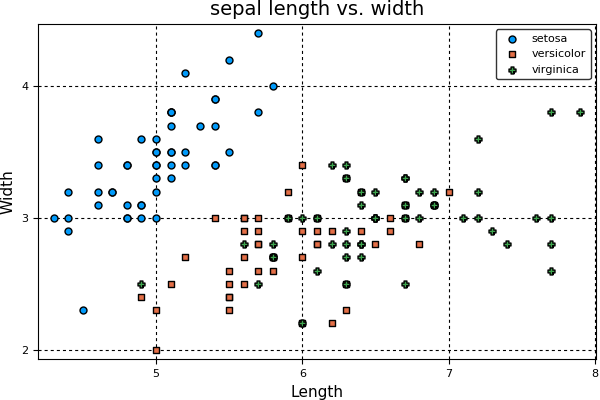

In [6]:
scatter(iris, :SepalLength, :SepalWidth, group=:Species, title = "sepal length vs. width", 
xlabel = "Length", ylabel = "Width", marker=([:circle :rect :cross], 5))

So, there are 150 data points, with 50 of each species.  Using a perceptron, we are going to try to find the linear separation between setosa and non-setosa, using sepal length and sepal width.  This is similar to the very nice [webpage](http://sebastianraschka.com/Articles/2015_singlelayer_neurons.html) by Sebastian Raschka, who created the image below. He covers all this material much better there, although his code is Python instead of Julia.
![Perceptron](/files/share/image/file/machineLearning/perceptron_schematic.png)

## The equations

For all $N$ dimensions $i$,

$$\quad\mathbf{w} ^\intercal \mathbf{x}= \sum_{i=1}^N w_ix_i + w_0$$

where $x$ is the input data and $w$ is the weight with $w_0$ as a bias term that is not multiplied by an input.

Squash output for each sample j,
$$\quad y_j = \begin{cases}\;1  \text{ if} \; \mathbf{w} ^\intercal \mathbf{x} \ge 0 \\
-1  \text{ otherwise} \end{cases}$$

update weights ($w_j$) for data at $j$,
$$\quad \Delta w_j = \eta \,(target^{(j)} - output^{(j)}) \,x_i^{(j)}$$

$\eta$ is the learning rate in the range 0 to 1.  target is the desired output, and output is $y_j$ calculated above.

In a two dimensional case,
$$\quad \Delta w_0 = \eta \,(target^{(j)} - output^{(j)})$$
$$\quad \Delta w_1 = \eta \,(target^{(j)} - output^{(j)})\,x_1^{(j)}$$
$$\quad \Delta w_2 = \eta \,(target^{(j)} - output^{(j)})\,x_2^{(j)}$$

Output and targets are always either 1 or -1, so weight update is 0 if they are the same, and $2\,\eta$ or $-2\,\eta$ if they are different.

### implementation
We will implement the algorithm step by step to see what the data looks like, then implement it in a loop to see how many iterations it takes to converge.

In [7]:
# create targets
@time target = [s=="setosa" ? 1 : -1 for s in iris[:Species]]

  0.053447 seconds (12.94 k allocations: 712.737 KiB)


150-element Array{Int64,1}:
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  ⋮
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1

In [8]:
# append a third column of 1's for the bias
@time X = hcat(iris[:SepalLength], iris[:SepalWidth],ones(150))

  0.406355 seconds (202.94 k allocations: 10.803 MiB, 2.71% gc time)


150×3 DataArrays.DataArray{Float64,2}:
 5.1  3.5  1.0
 4.9  3.0  1.0
 4.7  3.2  1.0
 4.6  3.1  1.0
 5.0  3.6  1.0
 5.4  3.9  1.0
 4.6  3.4  1.0
 5.0  3.4  1.0
 4.4  2.9  1.0
 4.9  3.1  1.0
 5.4  3.7  1.0
 4.8  3.4  1.0
 4.8  3.0  1.0
 ⋮            
 6.0  3.0  1.0
 6.9  3.1  1.0
 6.7  3.1  1.0
 6.9  3.1  1.0
 5.8  2.7  1.0
 6.8  3.2  1.0
 6.7  3.3  1.0
 6.7  3.0  1.0
 6.3  2.5  1.0
 6.5  3.0  1.0
 6.2  3.4  1.0
 5.9  3.0  1.0

In [9]:
# initialize w as small random numbers
@time w = rand(3)-0.5

  0.085289 seconds (32.27 k allocations: 1.603 MiB, 12.60% gc time)


3-element Array{Float64,1}:
 -0.349342 
  0.0500284
 -0.306284 

In [10]:
# calculate output (predicted y)
@time output = [o >= 0 ? 1 : -1 for o in X*w]

  0.232275 seconds (96.56 k allocations: 5.041 MiB)


150-element Array{Int64,1}:
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
  ⋮
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1

In [11]:
# calculate delta w0
η = 0.1
@time delta = η*(target.-output)


  0.112954 seconds (65.16 k allocations: 3.214 MiB)


150-element Array{Float64,1}:
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 0.2
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [12]:
error = count(x->x!=0, delta)/150

0.3333333333333333

In [13]:
@time cumsum(X.*delta)[end,:]

  1.620680 seconds (873.01 k allocations: 45.565 MiB, 2.25% gc time)


3-element DataArrays.DataArray{Float64,1}:
 50.06
 34.28
 10.0 

In [14]:
@time [sum(convert(Array,X.*delta)[:,i]) for i in 1:3]

  0.103627 seconds (29.43 k allocations: 1.625 MiB)


3-element Array{Float64,1}:
 50.06
 34.28
 10.0 

In [15]:
# put into loop and save weights and errors for plotting, η = 0.1
epochs = 30
w = rand(3)-0.5
η = .1
errors = Float64[]
weights = Array{Float64}(epochs,3)
for i in 1:epochs
    output = [o >= 0 ? 1 : -1 for o in X*w]
    delta = η*(target.-output)
    w += cumsum(X.*delta)[end,:]
    weights[i,:] = w
    push!(errors, count(x->x!=0, delta)/150)
end
errors

30-element Array{Float64,1}:
 0.333333  
 0.666667  
 0.333333  
 0.333333  
 0.666667  
 0.333333  
 0.333333  
 0.666667  
 0.333333  
 0.333333  
 0.653333  
 0.333333  
 0.333333  
 ⋮         
 0.0133333 
 0.00666667
 0.02      
 0.00666667
 0.0133333 
 0.00666667
 0.02      
 0.00666667
 0.0133333 
 0.0133333 
 0.00666667
 0.02      

In [16]:
weights

30×3 Array{Float64,2}:
   49.6061     34.7132      9.76309 
  -75.6339    -22.7268    -10.2369  
  -25.5739     11.5532     -0.236914
   24.4861     45.8332      9.76309 
 -100.754     -11.6068    -10.2369  
  -50.6939     22.6732     -0.236914
   -0.633882   56.9532      9.76309 
 -125.874      -0.486784  -10.2369  
  -75.8139     33.7932     -0.236914
  -25.7539     68.0732      9.76309 
 -148.214      11.5932     -9.83691 
  -98.1539     45.8732      0.163086
  -48.0939     80.1532     10.1631  
    ⋮                               
  -47.3739     80.2732     10.5631  
  -46.4739     80.7332     10.7631  
  -47.8539     79.9132     10.5631  
  -46.9539     80.3732     10.7631  
  -47.2539     80.1532     10.7631  
  -46.3539     80.6132     10.9631  
  -47.7339     79.7932     10.7631  
  -46.8339     80.2532     10.9631  
  -47.1339     80.0332     10.9631  
  -47.4339     79.8132     10.9631  
  -46.5339     80.2732     11.1631  
  -47.9139     79.4532     10.9631  


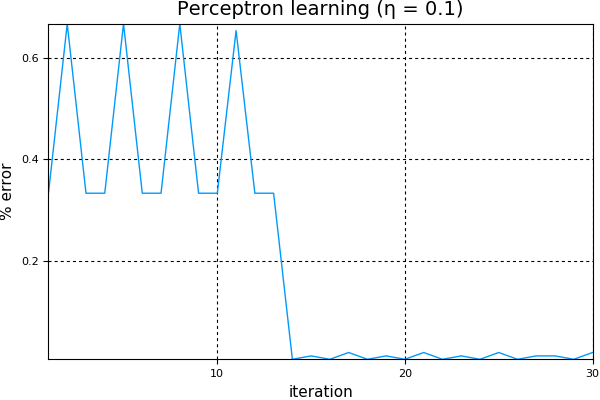

In [17]:
plot(errors, xlabel="iteration", ylabel="% error", legend=:none, 
title="Perceptron learning (η = $η)")

In [18]:
# loop η = .01
epochs = 40
w = rand(3)-0.5
η = .01
errors = Float64[]
for i in 1:epochs
    output = [o >= 0 ? 1 : -1 for o in X*w]
    delta = η*(target.-output)
    w += cumsum(X.*delta)[end,:]
    push!(errors, count(x->x!=0, delta)/150)
end
errors

40-element Array{Float64,1}:
 0.333333  
 0.666667  
 0.333333  
 0.333333  
 0.666667  
 0.333333  
 0.333333  
 0.666667  
 0.333333  
 0.333333  
 0.58      
 0.333333  
 0.333333  
 ⋮         
 0.66      
 0.333333  
 0.333333  
 0.38      
 0.333333  
 0.0133333 
 0.0133333 
 0.0133333 
 0.0133333 
 0.00666667
 0.0133333 
 0.0133333 


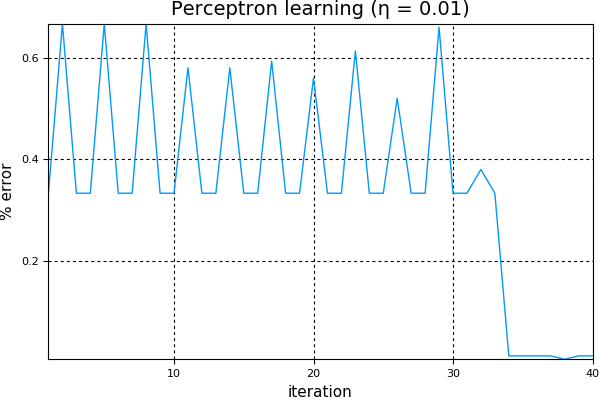

In [19]:
plot(errors, xlabel="iteration", ylabel="% error", legend=:none, 
title="Perceptron learning (η = $η)")

### Identify decision boundary

Plotting decision boundary

$ x_2 = \frac{-w_1}{w_2} x_1 - \frac{w_0}{w_2}$



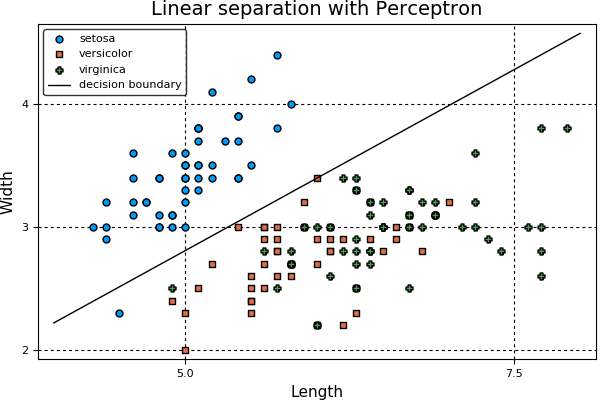

In [20]:
# in Julia, plot! modifies a previous plot
scatter(iris, :SepalLength, :SepalWidth, group=:Species, title = "Linear separation with Perceptron", 
xlabel = "Length", ylabel = "Width", marker=([:circle :rect :cross], 5))
x=linspace(4,8,50)
y= (-w[1]*x-w[3])/w[2]
plot!(x,y, linecolor=:black, label="decision boundary")


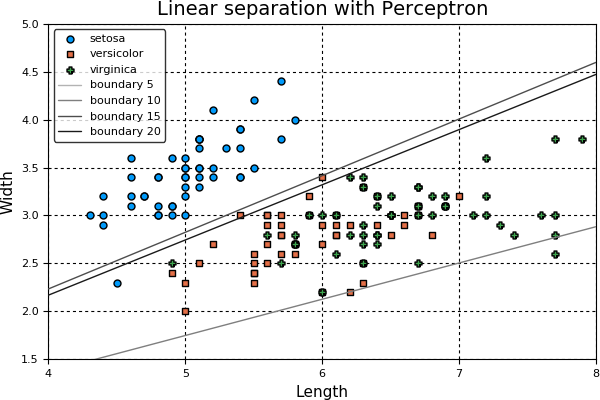

In [21]:
# draw boundaries at different numbers of iterations (note #5 isn't even in the plot frame)
xmin=4
xmax=8
ymin=1.5
ymax=5
scatter(iris, :SepalLength, :SepalWidth, group=:Species, title = "Linear separation with Perceptron", 
xlabel = "Length", ylabel = "Width", marker=([:circle :rect :cross], 5), xlims=(xmin,xmax), 
ylims=(ymin,ymax))
x=linspace(xmin,xmax,50)
i=5
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))
i=10
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))
i=15
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))
i=20
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))


# Adaline

The **ADA**pative **LI**near **NE**uron, developed by Widrow and Hoff (1960), uses a linear activation function to provide a graded feedback compared to Rosenblatt's original perceptron.  The weights are changed using the rule:

update weights ($w_j$) for data at $j$,
$$\quad \Delta w_j = \eta \,(target^{(j)} - output^{(j)}) \,x_i^{(j)}$$

Unlike the perceptron, this output is the weighted sum *without* squashing.  It is derived from taking the partial derviative of the cost function:

$$\quad J(\mathbf{w}) = \frac{1}{2} \sum_j(target^{(j)} - output^{(j)})^2$$

so that the update is in the opposite direction of the gradient:

$$\quad \Delta \mathbf{w} = - \eta\,\nabla \, J(\mathbf{w})$$

Thus, the term *gradient descent* for minimizing the cost function.


In [22]:
# loop η = .01
# gradient doesn't descend if use an η like above (it explodes!)
epochs = 50
w = zeros(3)
η = .01
costs = Float64[]
weights = Array{Float64}(epochs,3)
for j in 1:epochs
    delta = η*(target.-(X*w))
    w += cumsum(X.*delta)[end,:]
    weights[j,:] = w
    cost = (sumabs2(target.-(X*w)))/2
    push!(costs, cost)
end
costs

50-element Array{Float64,1}:
 49937.6        
     2.20933e8  
     9.77975e11 
     4.32907e15 
     1.91629e19 
     8.48257e22 
     3.75486e26 
     1.66211e30 
     7.35744e33 
     3.25682e37 
     1.44165e41 
     6.38155e44 
     2.82483e48 
     ⋮          
     1.77306e143
     7.84855e146
     3.47421e150
     1.53788e154
     6.80752e157
     3.01339e161
     1.3339e165 
     5.90457e168
     2.6137e172 
     1.15697e176
     5.12139e179
     2.26702e183


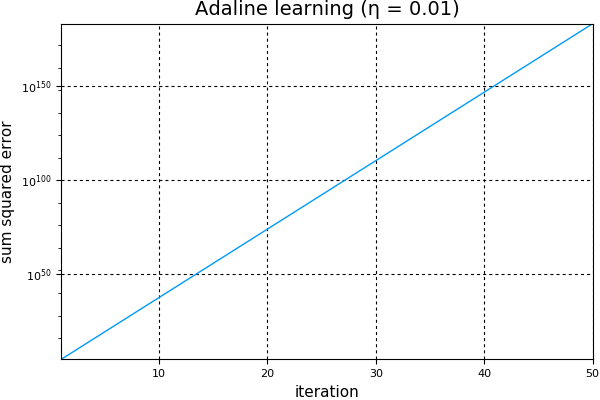

In [23]:
plot(costs, yscale=:log10, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (η = $η)")

In [24]:
# loop η = .0001
# gradient change is slow if η too small
epochs = 50
w = zeros(3)
η = .0001
costs = Float64[]
weights = Array{Float64}(epochs,3)
for j in 1:epochs
    delta = η*(target.-(X*w))
    w += cumsum(X.*delta)[end,:]
    weights[j,:] = w
    cost = (sumabs2(target.-(X*w)))/2
    push!(costs, cost)
end
costs

50-element Array{Float64,1}:
 64.4224
 62.8731
 62.2799
 61.7917
 61.3188
 60.8517
 60.3893
 59.9315
 59.4783
 59.0296
 58.5853
 58.1454
 57.7099
  ⋮     
 47.7852
 47.4525
 47.1231
 46.7969
 46.474 
 46.1543
 45.8378
 45.5244
 45.2141
 44.9069
 44.6027
 44.3016


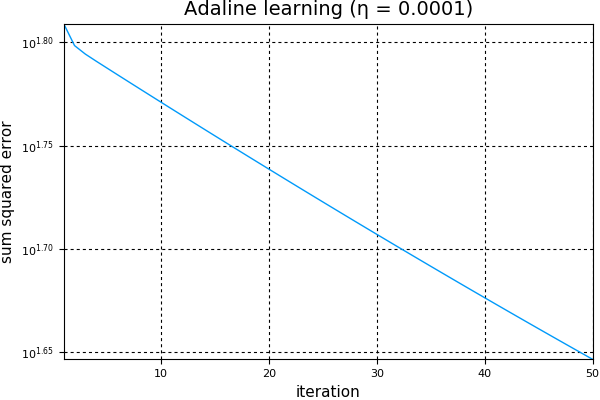

In [25]:
plot(costs, yscale=:log10, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (η = $η)")

In [26]:
weights

50×3 Array{Float64,2}:
 -0.03759    -0.01158     -0.005      
 -0.0520095  -0.0112249   -0.00609918 
 -0.058895   -0.00701519  -0.00593429 
 -0.0633235  -0.00157442  -0.00536141 
 -0.0669434   0.00424576  -0.00465848 
 -0.0702899   0.0101689   -0.00391572 
 -0.0735369   0.0161055   -0.00316242 
 -0.0767408   0.0220264   -0.00240807 
 -0.0799201   0.0279223   -0.00165574 
 -0.0830807   0.0337903   -0.000906422
 -0.0862248   0.0396295   -0.000160421
 -0.0893529   0.0454399    0.000582174
 -0.0924653   0.0512213    0.00132135 
  ⋮                                   
 -0.168181    0.191839     0.0193871  
 -0.170902    0.196891     0.0200396  
 -0.173609    0.201918     0.0206892  
 -0.176303    0.20692      0.0213357  
 -0.178984    0.211897     0.0219793  
 -0.181651    0.21685      0.0226199  
 -0.184305    0.221777     0.0232576  
 -0.186946    0.22668      0.0238924  
 -0.189574    0.231559     0.0245242  
 -0.192188    0.236413     0.0251532  
 -0.19479     0.241243     0.0257793  
 -

We can start the process in a better range if we normalize the input data around zero.  This will help the process zero in faster.

In [27]:
# scale data
Xs = Array{Float64}(150,3)
for i in 1:2
    Xs[:,i] = convert(Array, X[:,i].-mean(X[:,i]))./std(X[:,i]);
end
Xs[:,3] = ones(150);

In [28]:
# loop with scaling data η = .001
epochs = 20
w = zeros(3)
η = .001
costs = Float64[]
weights = Array{Float64}(epochs,3)
for i in 1:epochs
    delta = η*(target.-(Xs*w))
    w += cumsum(Xs.*delta)[end,:]
    weights[i,:] = w
    cost = (sum(abs2,(target.-(Xs*w))))/2
    push!(costs, cost)
end
costs

20-element Array{Float64,1}:
 56.6816
 43.8844
 34.9424
 28.6928
 24.3239
 21.269 
 19.1324
 17.6376
 16.5916
 15.8594
 15.3468
 14.9877
 14.7361
 14.5598
 14.4362
 14.3495
 14.2887
 14.2461
 14.2161
 14.195 


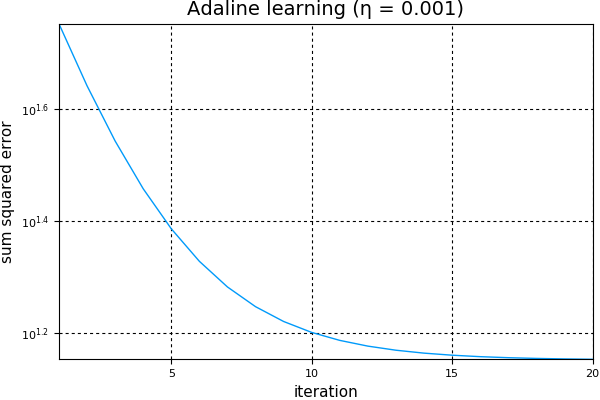

In [29]:
plot(costs, yscale=:log10, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (η = $η)")

In [30]:
# loop with scaling data η = .01
epochs = 20
w = zeros(3)
η = .01
costs = Float64[]
weights = Array{Float64}(epochs,3)
for i in 1:epochs
    delta = η*(target.-(Xs*w))
    w += cumsum(Xs.*delta)[end,:]
    weights[i,:] = w
    cost = (sum(abs2,(target.-(Xs*w))))/2
    push!(costs, cost)
end
costs

20-element Array{Float64,1}:
 39.2985
 24.8569
 18.7828
 16.1719
 15.0356
 14.5376
 14.3184
 14.2217
 14.179 
 14.1601
 14.1517
 14.148 
 14.1464
 14.1457
 14.1454
 14.1452
 14.1452
 14.1451
 14.1451
 14.1451


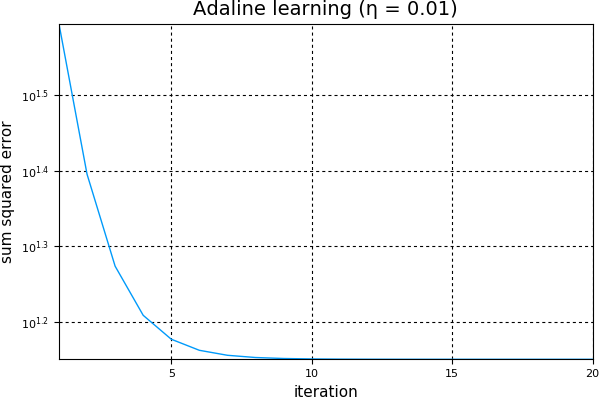

In [31]:
plot(costs, yscale=:log10, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (η = $η)")


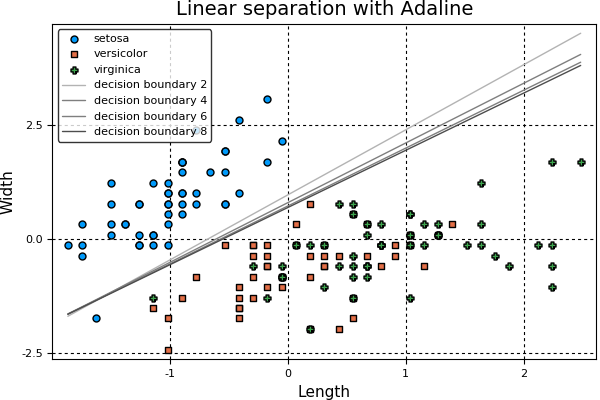

In [32]:
scatter(Xs[:,1],Xs[:,2], group=iris[:Species], title = "Linear separation with Adaline", 
xlabel = "Length", ylabel = "Width", marker=([:circle :rect :cross], 5))

x=linspace(minimum(Xs[:,1]),maximum(Xs[:,1]),50)
i=2
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,4)+1], 
label="decision boundary $i")
i=4
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,4)+1], 
label="decision boundary $i")
i=6
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,4)+1], 
label="decision boundary $i")
i=8
y= (-weights[i,1]*x-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:gray70, :gray50, :gray30, :gray10, :gray1][fld(i,4)+1], 
label="decision boundary $i")

In [33]:
weights

20×3 Array{Float64,2}:
 -1.01119   0.850414  -0.5     
 -0.366733  0.256572  -0.25    
 -0.786546  0.66045   -0.375   
 -0.510087  0.389007  -0.3125  
 -0.693103  0.570444  -0.34375 
 -0.571641  0.449479  -0.328125
 -0.652348  0.530029  -0.335937
 -0.598691  0.476422  -0.332031
 -0.634374  0.512089  -0.333984
 -0.610641  0.488361  -0.333008
 -0.626427  0.504145  -0.333496
 -0.615927  0.493646  -0.333252
 -0.622911  0.50063   -0.333374
 -0.618265  0.495984  -0.333313
 -0.621355  0.499074  -0.333344
 -0.6193    0.497019  -0.333328
 -0.620667  0.498386  -0.333336
 -0.619758  0.497477  -0.333332
 -0.620363  0.498082  -0.333334
 -0.61996   0.497679  -0.333333